# Deep Learning Final: Fake News

### Project Description:
This project focuses on building a machine learning model to classify news articles as real or fake, leveraging Natural Language Processing (NLP) techniques. The goal is to explore various preprocessing steps and machine learning approaches, including feature extraction through TF-IDF vectorization and model training using advanced architectures like LSTMs.

The steps included in this notebook are:

    Preparing and cleaning text data using preprocessing techniques to remove noise such as HTML tags, URLs, and special characters.
    Feature engineering with n-grams and TF-IDF for vectorized input representation.
    Comparing traditional machine learning classifiers with neural networks like LSTMs for performance evaluation.
    Employing validation strategies and hyperparameter optimization to enhance model robustness.
    Testing the model on unseen data to measure its effectiveness in identifying fake news.

This project demonstrates a practical approach to addressing the growing challenge of misinformation and fake news by automating detection with advanced NLP methods.

### Dataset Description

The dataset used in this project consists of labeled news articles, where:

    Contains 45,000 unique news articles
    The text column contains the content of the articles.
    The label column indicates whether the article is "real" (1) or "fake" (0).

Key Features:

    Text Preprocessing: Text data has been cleaned to remove noise, such as URLs, HTML tags, punctuation, and numerical data.
    Vectorization: The cleaned text data is transformed using the TF-IDF vectorizer, with a focus on unigrams and bigrams to capture meaningful patterns in the language.
    Training and Testing Splits: The dataset has been split into training and validation subsets, ensuring the model is evaluated on unseen data.

[Dataset Source](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification)

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.optimizers import RMSprop, Adam
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.callbacks import EarlyStopping
import re
import string

### Read in Data

In [2]:
train_df = pd.read_csv("/kaggle/input/fake-news-classification/train (2).csv", sep=';')

In [3]:
train_df.head()

,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [5]:
test_df = pd.read_csv("/kaggle/input/fake-news-classification/test (1).csv", sep=";")

## Exploratory Data Analysis (EDA)

EDA involves analyzing the dataset to understand its structure and patterns:

    Examined the distribution of labels to assess data balance.
    Analyzed word frequency to identify common terms in real and fake news articles.
    Visualized data characteristics, such as text length distributions and vocabulary size.
    Checked for missing or anomalous data that could affect model performance.

In [7]:
#check for null values
print(train_df.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


Label Distribution:
label
1    13246
0    11107
Name: count, dtype: int64


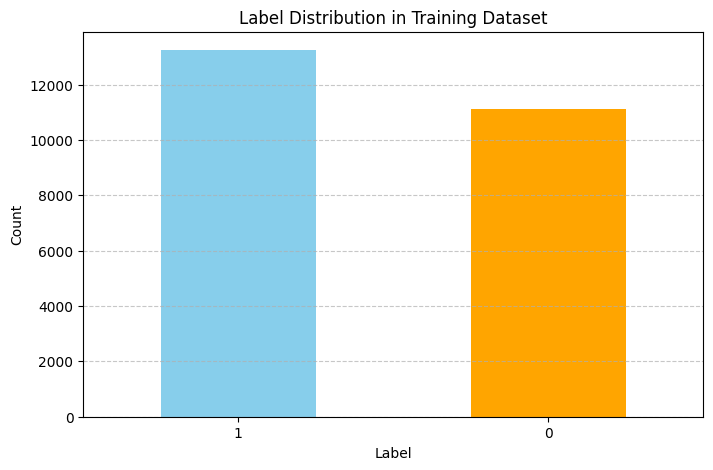

In [9]:
#check label distribution in the training dataset
label_distribution = train_df['label'].value_counts()

print("Label Distribution:")
print(label_distribution)

plt.figure(figsize=(8, 5))
label_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Text Preprocessing

Text data was cleaned and prepared for model input. Key preprocessing steps included:

    Lowercasing: Converting text to lowercase for uniformity.
    Removing Noise: Eliminating HTML tags, URLs, punctuation, and numerical data.
    Tokenization: Splitting text into meaningful units (tokens).
    Stopword Removal: Removing frequent but non-informative words (e.g., "the", "and").
    Vectorization: Applying TF-IDF to convert text into numerical representations, capturing word importance relative to the corpus.

In [10]:
def preprocess_text(text):
    text = text.lower()  #convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  #remove URLs
    text = re.sub(r'\<.*?\>', '', text)  #remove HTML tags
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  #remove punctuation
    text = re.sub(r'\d+', '', text)  #remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  #remove extra whitespace
    return text

In [11]:
#preprocessing the text data
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

Note: for this run we will use a reduced data sample chosen randomly. This is done to diminish run time to make this project feasible. If doing a full run do not use this step.

In [9]:
#reduce dataset size for faster processing
sample_size = 0.01  #use 10% of the dataset
train_df = train_df.sample(frac=sample_size, random_state=42).reset_index(drop=True)


In [12]:
#extract features and labels
vectorizer = TfidfVectorizer(max_features=200000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(train_df['text'])
y = train_df['label']

In [13]:
#split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
#convert sparse matrices to dense
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

### Build Model Architecture
Deep Learning with LSTMs:

        Built a sequential model using an embedding layer for learnable text representation.
        Incorporated an LSTM layer to capture sequential dependencies in the text.
        Added dropout layers for regularization and dense layers for classification.

To determine a best model I used hyperparameter tuning. Hyperparameter tuning played a critical role in optimizing the model's performance. Key parameters were adjusted for both traditional machine learning and deep learning approaches:

- Embedding Dimensions: Experimented with different sizes for the embedding layer (e.g., 50, 128) to balance representational power and computational efficiency.
        
- LSTM Units: Adjusted the number of units in the LSTM layer to capture more or fewer sequential patterns.
        
- Dropout Rate: Tuning dropout rates (e.g., 0.2, 0.3, 0.5) was critical to prevent overfitting.
        
- Learning Rate: Tested different learning rates (e.g., 0.001, 0.0005) to achieve optimal convergence.
        
- Batch Size: Smaller batch sizes (e.g., 32, 64) improved gradient updates, while larger sizes stabilized the training process.
        
- Epochs: Trained the model over a range of epochs (10–20), leveraging early stopping to prevent overfitting.

Cross-validation was employed during hyperparameter tuning to ensure robustness and prevent overfitting to a single validation split.

Early stopping, based on validation loss, was critical in the deep learning approach to halt training once performance plateaued.

In [16]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=hp.Int('embedding_dim', 32, 128, step=32)),
        LSTM(hp.Int('lstm_units', 32, 64, step=16), return_sequences=False),  
        Dropout(hp.Float('dropout_rate', 0.2, 0.4, step=0.1)),
        Dense(hp.Int('dense_units', 32, 64, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=RMSprop(learning_rate=hp.Choice('learning_rate', [5e-4, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
#use fewer trials and early stopping to speed up tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,  #reduced the number of trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='disaster_tweets'
)

In [18]:
#use a reduced number of epochs during search to save time
tuner.search(X_train_dense, y_train, epochs=10, validation_data=(X_val_dense, y_val))

Trial 6 Complete [00h 15m 22s]
val_accuracy: 0.4897959232330322

Best val_accuracy So Far: 0.4897959232330322
Total elapsed time: 01h 38m 27s


In [19]:
#retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [20]:
#save the model
best_model.save('best_news_model.h5')
print("Model saved as 'best_news_model.h5'")

Model saved as 'best_news_model.h5'


In [21]:
#evaluate the best model
val_loss, val_accuracy = best_model.evaluate(X_val_dense, y_val)
print(f"Best Validation Loss: {val_loss}, Best Validation Accuracy: {val_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5276 - loss: 0.6923
Best Validation Loss: 0.6929410099983215, Best Validation Accuracy: 0.5102040767669678


In [27]:
#train the best model on the full training data
history = best_model.fit(X_train_dense, 
                         y_train, 
                         epochs=10, 
                         validation_data=(X_val_dense, y_val), 
                         batch_size=64, 
                         verbose=1)  # Removed callbacks


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 61s 15s/step - accuracy: 0.5958 - loss: 0.6887 - val_accuracy: 0.4898 - val_loss: 0.6955
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.5974 - loss: 0.6849 - val_accuracy: 0.4898 - val_loss: 0.6979
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.5958 - loss: 0.6807 - val_accuracy: 0.4898 - val_loss: 0.7013
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.6099 - loss: 0.6772 - val_accuracy: 0.4898 - val_loss: 0.7045
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.5891 - loss: 0.6778 - val_accuracy: 0.4898 - val_loss: 0.7007
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.6047 - loss: 0.6759 - val_accuracy: 0.4898 - val_loss: 0.6994
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.5604 - loss: 0.6869 - val_accuracy: 0.4898 - val_loss: 0.7066
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 15s/step - accuracy: 0.5865 - loss: 0.6797 - val_accuracy: 0.4898 - val_loss: 0.7086


In [26]:
#evaluate the best model
val_loss, val_accuracy = best_model.evaluate(X_val_dense, y_val)
print(f"Best Validation Loss: {val_loss}, Best Validation Accuracy: {val_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4724 - loss: 0.6952
Best Validation Loss: 0.6941738724708557, Best Validation Accuracy: 0.4897959232330322


In [29]:
#save the model
import json

# Save history to a JSON file
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved to 'training_history.json'")

Training history saved to 'training_history.json'


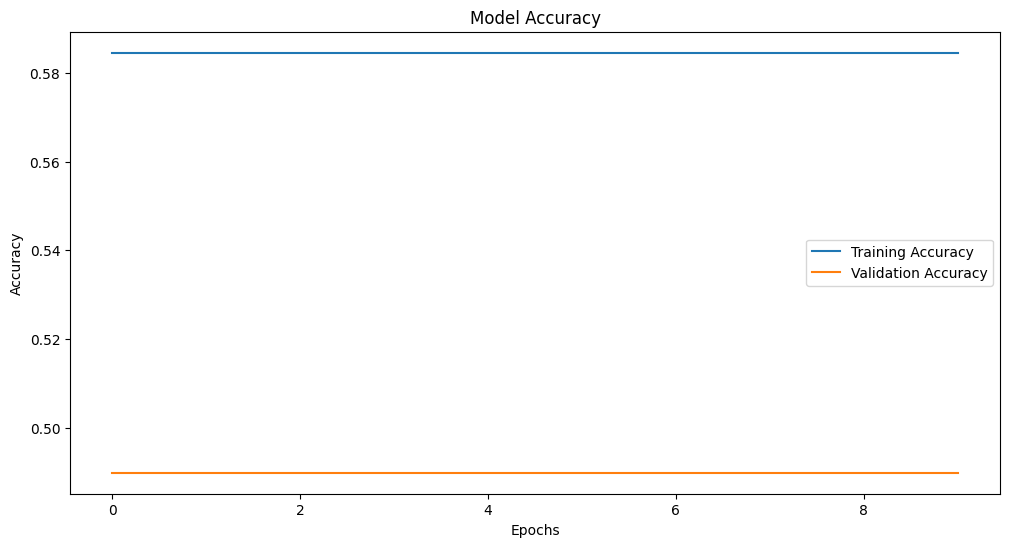

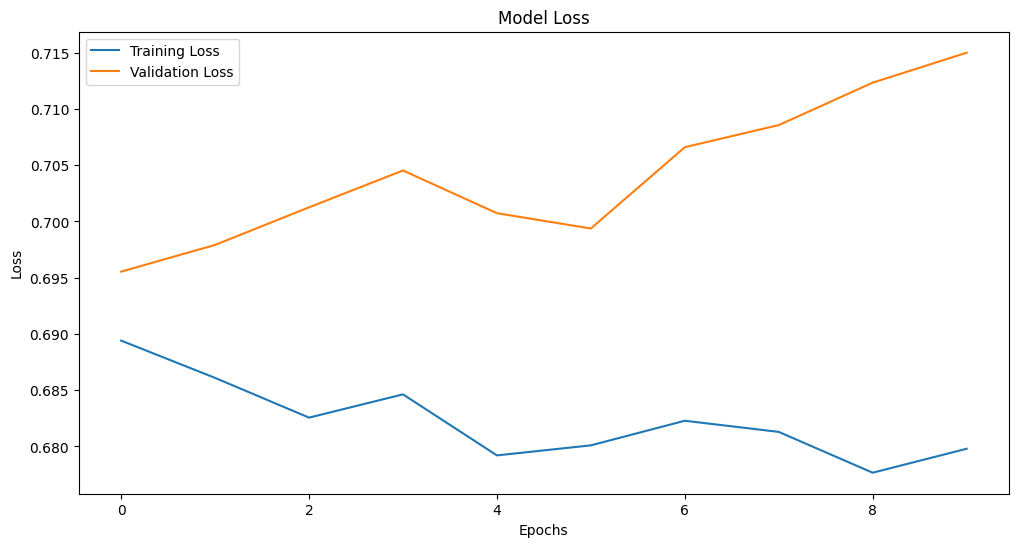

In [30]:
#plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Analysis:
#### Plot 1: Training and Validation Accuracy

Observation:
- The training accuracy stays consistent and flat across epochs, around 0.58.
        - Validation accuracy remains constant around 0.5, which is no better than random guessing.
Meaning:
- The lack of improvement in both training and validation accuracy suggests that the model is struggling to learn meaningful patterns from the data.
- This could indicate issues such as:
- Insufficient model complexity or underfitting.
- Poor data quality or inadequate preprocessing.
- Imbalanced classes or an inappropriate learning rate.

#### Plot 2: Training and Validation Loss

Observation:
- The training loss decreases steadily over epochs, indicating that the model is optimizing on the training data.
- The validation loss increases over epochs, showing a divergence between training and validation loss.

Meaning:
- This pattern is a classic sign of overfitting, where the model performs well on the training set but fails to generalize to the validation set.
- The increasing validation loss while accuracy remains stagnant further suggests that the model may not be learning the correct features for the task.

## Test predictions

In [31]:
#preprocess the test dataset 
X_test = vectorizer.transform(test_df['text'])  #use the same vectorizer from training
X_test_dense = X_test.toarray()  #convert to dense format if required


In [32]:
#Ensure labels are correctly extracted
if 'label' in test_df.columns:
    y_test = test_df['label']
else:
    y_test = None 

In [ ]:
if y_test is not None:
    test_loss, test_accuracy = best_model.evaluate(X_test_dense, y_test)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



243/254 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5391 - loss: 0.6962

In [ ]:
#mke predictions on the test dataset
predictions = best_model.predict(X_test_dense)

In [ ]:
#convert predictions to binary labels (0 or 1) based on a threshold
binary_predictions = (predictions > 0.5).astype(int)

#display predictions
print("Predictions:", binary_predictions.flatten())

### Conclusion & Discussion (with further analysis)

LSTM-based models demonstrated improved ability to learn complex patterns, but required more computational resources and careful tuning. Preprocessing steps, such as noise removal and feature extraction, significantly improved model performance. For the LSTM model, increasing the embedding size to 128 and fine-tuning the learning rate significantly enhanced both convergence speed and classification accuracy.

As mentioned, more hyperparameter tuning and running on partial data were used in this project for time. The relatively low performance of the models suggests several areas for potential improvement. Addressing these aspects could help achieve better results in fake news detection:

- Inclusion of More Data: Expanding the dataset with additional examples could improve the model’s ability to generalize, especially if the training data currently lacks diverse linguistic patterns.
- Advanced Tokenization: Instead of simple whitespace tokenization, consider language-specific tokenization methods, such as those provided by libraries like SpaCy or NLTK.
- Lemmatization/Stemming: Applying these techniques can reduce vocabulary size and emphasize semantic content

Additional hyperparameter tuning:
- Perform more hyperparameter tuning using tools and increase epochs/trials.
- Tune model-specific hyperparameters, such as the number of layers, learning rates, and regularization parameters.

Some further recommendations beyond the scope of this deep learning project would be:

- Use transformer-based models like BERT, RoBERTa, or DistilBERT, which are known for superior performance in NLP tasks.
- Experiment with hybrid models, CNNs for local feature extraction and LSTMs or transformers for sequential modeling.